# Analyze A/B Test Results 

This project have been organized into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)
 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.


<a id='probability'></a>
## Part I - Probability


In [1]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>

**a.** Reading the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
#reading and exploring the "ab_data.csv" dataset
df = pd.read_csv("ab_data.csv")

**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

**c.** The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [5]:
df[df.converted == 1].shape[0]/df.shape[0]

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
misfit = df.query("group == 'treatment' and landing_page!='new_page'").shape[0]
misfit = misfit + df.query("group == 'control' and landing_page != 'old_page'").shape[0]
misfit

3893

**f.** Do any of the rows have missing values?

In [7]:
df.isnull().sum().sum()

0

### Cleaning-step-01
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


We should **drop** the mis fit rows and store the resulted DataFrame in **df2**

In [8]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df[((df.group=='treatment')&(df.landing_page=='new_page'))|((df.group=='control')&(df.landing_page=='old_page'))]

In [9]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

**a.** How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2.user_id.value_counts()[df2.user_id.value_counts()>1]

773192    2
Name: user_id, dtype: int64

**c.** Display the rows for the duplicate **user_id**? 

In [12]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [13]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2.drop(axis=0, index=2893, inplace=True)
# Check again if the row with a duplicate user_id is deleted or not
df2[df2.user_id == 773192]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


### Calculating Probabilities:

**a.** What is the probability of an individual converting regardless of the page they receive  $p_{population}$?<br><br>

In [14]:
df2.converted.mean()

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
p_control = df2.query("group == 'control'").converted.mean()
p_control

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
p_treatment = df2.query("group == 'treatment'").converted.mean()
p_treatment

0.11880806551510564

**d.** What is the difference between the conversion rates for the two groups?

In [17]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff =  p_treatment - p_control
obs_diff

-0.0015782389853555567

**e.** What is the probability that an individual received the new page?

In [18]:
df2[df2.landing_page=='new_page'].shape[0]/df2.shape[0]

0.5000619442226688

**f.** for how long has been this test running?

In [19]:
df2.timestamp = pd.to_datetime(df2.timestamp)
df2.timestamp.max()-df2.timestamp.min()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Timedelta('21 days 23:59:49.081927')

**g.** Consider the results from parts (a) through (e) above, the explaination below is to whether the new `treatment` group users lead to more conversions.

>**Even thought the conversion rate on the old page is slightly highter than the conversion rate on the new one, We can't conclude that the new page is generating the same or even less conversion rate than the old one just yet, we need to perform furthur statistical analysis on the data to be able to jump to that conclusion**

>**Note that: we didn't account for the fact that this expirement ran only for 21 days on old customers, so we're propably at least dealing with both (Novely effect and change aversion), plus we dodn't account for changes in behaviour based on time of simply #days or differnt seasonal events.**

<a id='ab_test'></a>
## Part II - A/B Test

considering that I need to make the decision just based on all the data provided.  

**We can pose a Hypothesis test ..**

Assuming that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%,
using  the conversion rate for the old and new pages as the metric we test on.

>**$H_0$** : **$p_{new}$** - **$p_{old}$** <= 0

>**$H_1$** : **$p_{new}$** - **$p_{old}$** > 0

### Null Hypothesis $H_0$ Testing

Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, I will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 


**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [20]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [21]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>

In [22]:
n_new = df2[df2.group == 'treatment'].shape[0]
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old = df2[df2.group == 'control'].shape[0]
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>

In [24]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1], size=n_new, p=[1-p_new, p_new])
new_page_converted.mean()

0.11882871103158764

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> 

In [25]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0,1], size=n_old, p=[1-p_old,p_old])
old_page_converted.mean()

0.11973236780153365

**g.** The difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [26]:
simulated_obs_diff = new_page_converted.mean()-old_page_converted.mean()
simulated_obs_diff

-0.0009036567699460124


**h. Sampling distribution** <br>
Use Bootstarpping 10,000 times using the same simulation process you used in parts (a) through (g) above. 

In [27]:
# Sampling distribution 
p_diffs = []

new_page_convert = np.random.binomial(n_new,p_new,10000)/n_new
old_page_convert = np.random.binomial(n_old,p_old,10000)/n_old
p_diffs = new_page_convert - old_page_convert

**i. Histogram**<br> 

Plot a histogram of the **p_diffs**. 

Also, mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  


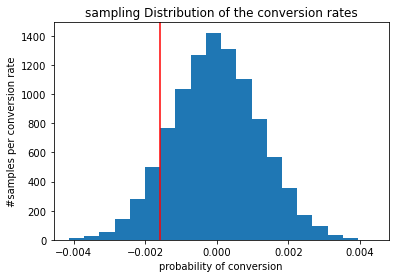

In [28]:
plt.hist(p_diffs, bins=20)
plt.axvline(x=obs_diff, color='r')
plt.xlabel("probability of conversion")
plt.ylabel("#samples per conversion rate")
plt.title("sampling Distribution of the conversion rates")
plt.show();

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [29]:
null_diff = np.random.normal(0, p_diffs.std(), p_diffs.size)
(null_diff > obs_diff).mean()

0.9051

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

### **Answer:**
    
  - I've caculated the p-value of this sampling distribution.
  - Since, p-value = 0.9022 > 0.05 "Type I error rate" we specificed for this test,
  - The result is not Statistically significant so we **Fail to reject the Null Hypothesis**.
  - Comapny Advice: **Keep the old page**.



**l. Using Built-in Methods for Hypothesis Testing**<br>
- We could also use a built-in to achieve similar results by performing a **z-test**.
- Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

In [30]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query("landing_page=='old_page' and converted==1").shape[0]

# number of conversions with the new_page
convert_new = df2.query("landing_page=='new_page' and converted==1").shape[0]

# number of individuals who were shown the old_page
n_old = df2.query("landing_page=='old_page'").shape[0]

# number of individuals who received new_page
n_new = df2.query("landing_page=='new_page'").shape[0]

**m.** Now computing z test statistic and p-value.

In [31]:
import statsmodels.api as sm

z_score, p_value = sm.stats.proportions_ztest(count=[convert_new, convert_old],
                                              nobs=[n_new,n_old], alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

### **Answer:**

**After perfoming the z-test,**

 - We have a $z_{score}$ = -1.31  >  $z_{0.05}$ = -1.645 (critical z-score for a one-tailed test);

 - The result isn't statistically significant, we fail to reject the Null Hypothesis;
 
 - Notice that: the result is consistant with the results we obtained in parts **j.** and **k.**

 - We advice the company to **Keep the old page**. 

<a id='regression'></a>
### Part III - A regression approach

In this final part, I will be performing regression model on the data to confirm my A/B test results in Part II.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Answer: Logestic Regression.** 

**b.** The goal is to use **statsmodels** library to fit Logistic regression model to see if there is a significant difference in conversion based on the page-type a customer receives. 

In [32]:
df2['intercept'] = 1

df2[['other', 'ab_page']] = pd.get_dummies(df['group'])
df2.drop(['other','group'], axis=1, inplace=True)

<ipython-input-32-9bb552df83a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['intercept'] = 1
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

**c.** Instantiate the regression model on the two columns created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [33]:
ml= sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = ml.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Providing the summary of my model below, and use it as necessary to answer the following questions.

In [34]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-02-26 12:46 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  



### **Answer:**

 - The **p-value** associated with the Regression model for **ab_page** = 0.1899.
 
 - The difference in p-values in both test results are due to the posed Hypothesis:
         
   
  > 1- In Part II: it was **one-tailed test** where, 
  $H_0$: the conversion rate on the new page is less than or equal to
         the conversion rate on the old page.
          
         The z-test in part II on the other hand is one-tailed since it has inequality signs
         in the hypotheses.
         
   > 2- In the regrission model here: it's **two-tailed test** where, 
         $H_{0}$: the conversion rate on the new page is higher than
         the conversion rate on the old page.
         
         This is because a high p-value for ab_page in the regression model means that there is no
         correlation between the landing page type and the conversion rate. 
         This implies that p_new is equal to p_old.
         which is the null hypothesis of a two tailed test:
         Ho: p_new = p_old
         H1: p_new != p_old
 
 - Since, p-value in the summary = 0.1899 > 0.05 (Type I error rate),
 - The result isn't statistically sognificant, so we **fail to reject the Null Hypothesis**.
 - Our Advice for the Company: "still" **Keep the old page**

**f.** Now, Let's consider other things that might influence whether or not an individual converts.

Discuss why it is a good idea to consider other factors to add into your regression model.

Are there any disadvantages to adding additional terms into your regression model?

### **Answer:**
   - Since the only suggested effect we have on our conversion rate simply due to old, or new page, we ignore many factors that could affect the action of conversion:
   - Some are simply focused on the conditions of the expirement it self (the users involved in the expirement, the expirement run time, and any behaviour based on seasonal events)
   - Other are simple feautres that could correlate to the website, where are the users live, the popularity of the company in different location, the cost of conversion and son on.
   - Adding multiple feautres to the model to study it's effect on the conversion rate will help us eliminate any varables that can mislead on how much actual effect does changing the landing page affected our cinversion rate.
   - Yet, Adding more feautres rises new issues like the validity of Type I error rate to compare with, as well as the multi collanirity that could exist between those features and their effect in each other. 

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also I'll add an effect based on which country a user lives in. 
 
 Provide the statistical output as well as a written response to answer this question.

In [35]:
#reading the "countries.csv" data into a new dataframe
countries = pd.read_csv("countries.csv")

In [36]:
# Join with the df2 dataframe
df_merged = df2.merge(countries, on='user_id')

In [37]:
# Create the necessary dummy variables
df_merged[['UK', 'US', 'CA']] = pd.get_dummies(df_merged['country'])
df_merged['intercept'] = 1

lm1 = sm.Logit(df_merged['converted'], df_merged[['intercept', 'UK', 'US']])
result1= lm1.fit()
result1.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2022-02-26 12:46 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
UK           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
US            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

**h. Fitting the model and obtaining results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Let's Create the necessary additional columns, and fit the new model.** 


In [38]:
# Fit your model, and summarize the results
df_merged['intercept'] = 1
df_merged['UK_ab_page'] = df_merged['UK'] * df_merged['ab_page']
df_merged['US_ab_page'] = df_merged['US'] * df_merged['ab_page']

ml = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK','UK_ab_page',
                                                 'US', 'US_ab_page']])
results = ml.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-02-26 12:46 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
UK           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK_ab_page   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
US           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
US_ab_page    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

In [39]:
np.exp(results.params)

intercept     0.137178
ab_page       0.979646
UK            0.982625
UK_ab_page    0.954198
US            0.994272
US_ab_page    1.031896
dtype: float64

In [40]:
1/_

intercept     7.289813
ab_page       1.020776
UK            1.017682
UK_ab_page    1.048001
US            1.005761
US_ab_page    0.969090
dtype: float64

### **Answer:**
   
     1- Concerning **p-value**s:
   
   - p-value of all factors are larger than **0.05 Type I error rate** 
   - which is not a statistically significant result,
   - meaning we **fail to reject the Null Hypothesis**,
   - we should **keep the old page**.
       
    2- concerning the affect of both page and country on the conversion rate, the model tells us the following:
    
  
   - If a user uses the new page he's 1.02 times more likely to purchase from the website (convert), holding all other variables constant.
   - If a user lives in Canada they're 1.018 times more likely to purchase from the website (convert) than a user lives in the United Kingdom, holding all other variables constant.
   - If a user lives in Canada they're 1.005 times more likely to purchase from the website (convert) than users in the United States, holding all the other variables constant.
   - If a user lives in Canada and uses the new page they're 1.04 times more likely to purchase from the website (convert) than users lives in the United Kingdom and using the new page, holding all the other variables constant.
   - If a user lives in Canada and uses the new page they're 0.041 times less likely to purchase from the website (convert) than users lives in the United States and using the new page, holding all the other variables constant.
         

## Final Conclusion :

### After extensive various statistical testing, we advice the comapny to ...

  **1-** In light of the data in hand , **Keep the old page running.**

  **2-** Add Financial data of **profit margin** on every conversion and **the cost of deploying the old vs. new page** into the miss to get a more clear financial insights about the result.

  **3- Run the test for a while longer**, because clearly there're both **Novely and change aversion effects** in play in this dataset, to make sure the test runs long enough to **account for changes in behaviour based on time or seasonal/events**. 